# 匯入所需套件

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# 載入並整理MNIST資料集

In [2]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

# 建立VAE

## 建立encoding & decoding層

### 調整部分=> 層數增為三層&調整參數

In [3]:
x = Input(shape=(784,))

en_1 = Dense(128,activation='sigmoid')
en_2 = Dense(64, activation = 'relu')
en_3 = Dense(32, activation = 'sigmoid')

en_mean = Dense(2)
en_log_var = Dense(2)

de_1 = Dense(784, activation='sigmoid')
de_2 = Dense(128, activation='sigmoid')
de_3 = Dense(64, activation = 'sigmoid')

In [4]:
en_x = en_3(en_2(en_1(x)))

z_mean = en_mean(en_x)
z_log_var = en_log_var(en_x)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
z = Lambda(sampling, output_shape = (2,))([z_mean, z_log_var])

### 定義VAE decoding部分

In [7]:
z_input = Input(shape=(2,))
x_hat = de_1(de_2(de_3(z_input)))

In [8]:
x_hat = de_1(de_2(de_3(z)))
VAE = Model(x,x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
______________________________________________________________________________________________

# 建立Loss函數

In [9]:
recon_loss = 784*losses.mean_squared_error(x,x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis = 1)
kl_loss *= -0.5

vae_loss = K.mean(recon_loss + kl_loss)
VAE.add_loss(vae_loss)

# 訓練VAE

In [10]:
VAE.compile(optimizer = Adam())

In [11]:
VAE.fit(X_train,batch_size=512, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 54us/sample - loss: 65.3126
Epoch 2/5
60000/60000 [==============================] - 3s 46us/sample - loss: 52.9182
Epoch 3/5
60000/60000 [==============================] - 3s 48us/sample - loss: 52.8323
Epoch 4/5
60000/60000 [==============================] - 2s 42us/sample - loss: 52.7946
Epoch 5/5
60000/60000 [==============================] - 2s 41us/sample - loss: 52.6737


In [12]:
VAE.save_weights('VAE_handwriting_modelweight.h5')

# 視覺化呈現

In [13]:
VAE_en = Model(x,z_mean)
VAE_en.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 110,882
Trainable params: 110,882
Non-trainable params: 0
_________________________________________________________________


In [14]:
VAE_de = Model(z_input, de_1(de_2(de_3(z_input))))
VAE_de.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
Total params: 109,648
Trainable params: 109,648
Non-trainable params: 0
_________________________________________________________________


In [15]:
idx = np.random.randint(X_train.shape[0])
indices = np.random.randint(X_train.shape[0], size = 6000)
VAE_latents = VAE_en.predict(X_train[indices])

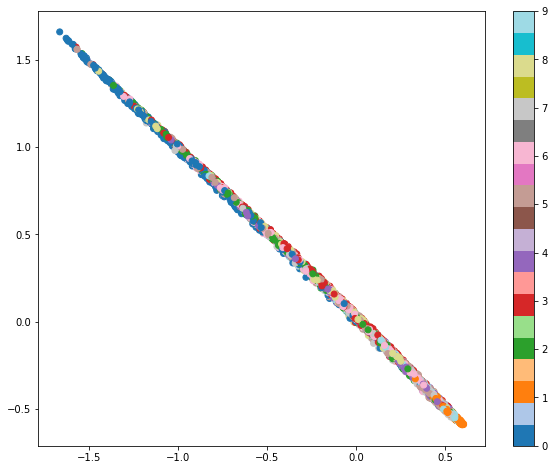

In [16]:
plt.figure(figsize = (10,8))
plt.scatter(VAE_latents[:,0],VAE_latents[:,1],c = y_train0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()

## Decoder視覺化呈現

In [17]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [18]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_de.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

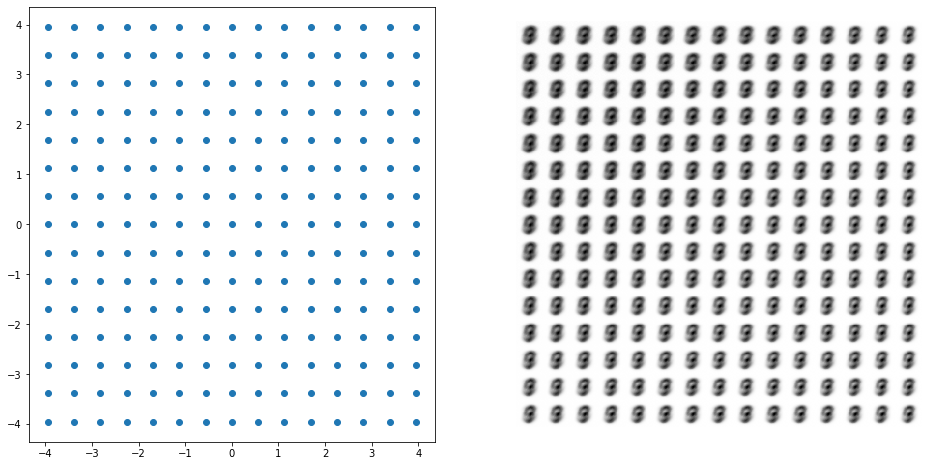

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# 動態比較

In [20]:
idx_1, idx_2 = np.random.randint(X_train.shape[0],size = 2)

def inbetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_en.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_en.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [21]:
interact(inbetween, t = FloatSlider(value = 0, min = 0, max = 1.0, step = 0.02));

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…